# Add your own Objects and Styles to Image Generation Models

This notebook provides a practical framework for fine-tuning existing image generation models, such as Stable Diffusion, using [DreamBooth](https://huggingface.co/docs/diffusers/training/dreambooth) and Azure Machine Learning. The primary goal is to enable the model to generate images of specific subjects or concepts, based on a set of sample images. This process can be used to insert a specific object into entirely new contexts or scenes.

Potential business applications facilitated by this framework include content creation, product visualization, advertising and marketing, as well as education and training. The fine-tuning operation will be executed using Azure Machine Learning, leveraging its scalability for training on powerful GPU compute resources and its capabilities for managing and tracking experiments and image datasets.

In this solution framework, you will:

1. Connect to your Azure Machine Learning Workspace and establish the required resources.
2. Provide training images of the specific subject to be incorporated into the image generation model.
3. Configure and initiate the fine-tuning training job.
4. Review the experiment results and retrieve key artifacts, including model checkpoints.
5. Generate new images of your chosen subject in diverse scenes.

This notebook is designed as a solution template for leveraging Azure ML and DreamBooth for fine-tuning image generation models within business contexts, providing a solution framework that can be adapted to specific needs and applications.

__Development resources__:
- Dreambooth scripts: https://github.com/huggingface/diffusers/tree/main/examples

# Setup

In [ ]:
# uncomment if you need to install the required packages in the active environment of your notebook
# %pip install --upgrade -r ../requirements.txt

In [1]:
import sys
sys.path.insert(0, '..')
import os
import shutil
import random
from azure.ai.ml import automl, Input, Output, MLClient, command, load_job
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

from azure.ai.ml.entities import Data, Environment, AmlCompute
from azure.ai.ml.constants import AssetTypes
from azure.core.exceptions import ResourceNotFoundError

import matplotlib.pyplot as plt

import mlflow
from mlflow.tracking.client import MlflowClient

from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch
from utils import show_images

In [55]:
# Set central variables
subscription_id =  "Your Azure subscription ID"
resource_group = "gencv" # adjust if you have chosen a different name 
workspace_name = "gencv-workspace" # adjust if you have chosen a different name

local_train_data = './train-data/hairwax/' # Azure ML dataset will be created for training on this content
generated_images = './results/hairwax'

azureml_dataset_name = 'hairwax' # Name of the dataset 
train_target = 'gpu-cluster'
experiment_name = 'dreambooth-finetuning'


## Connect to Azure Machine Learning Workspace

In [ ]:
# Set credential
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

# Get handle to Workspace 
try:
    ml_client = MLClient.from_config(credential=credential)
except Exception as ex:

    ml_client = MLClient(subscription_id=subscription_id, 
                         resource_group_name= resource_group,
                         workspace_name= workspace_name,
                         credential= credential)
    
print ('Test Workspace access by listing compute resources ... ')
print([compute.name for compute in ml_client.compute.list()])

## Establish required Azure ML Resources

The subsequent steps will lead to the creation of the following resources:

1. A GPU cluster for the fine-tuning job.
2. An Azure ML Dataset registration for the training images.
3. A Python environment registration for executing the fine-tuning job.  

__Note__: These steps only need to be performed once. If you've already executed this cell, you may proceed directly to the [Show Training Samples](#Show-Training-Samples) section. If updates to these resources are necessary, feel free to re-run these cells.

In this demonstration, we utilize low-priority compute for cost efficiency. While low-priority VMs offer significant cost savings compared to standard dedicated compute, availability may fluctuate, and there is a risk of training jobs being pre-empted.


In [4]:
try:
    _ = ml_client.compute.get(train_target)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=train_target,
        type="amlcompute",
        size="Standard_NC96ads_A100_v4", # 4 x A100, 80 GB GPU memory each
        tier="low_priority",
        idle_time_before_scale_down=600,
        min_instances=0,
        max_instances=2,
    )
    ml_client.begin_create_or_update(compute_config)

Found existing compute target.


In [ ]:
# Register dataset
my_data = Data(
    path= local_train_data,
    type= AssetTypes.URI_FOLDER,
    description= "Training images for Dreambooth finetuning",
    name= azureml_dataset_name
)
ml_client.data.create_or_update(my_data)

In [ ]:
environment = Environment(
    image="mcr.microsoft.com/azureml/aifx/stable-ubuntu2004-cu115-py38-torch1110:biweekly.202302.1",
    conda_file="./dreambooth-conda.yaml",
    name="dreambooth-env",
    description="Dreambooth training environment",
)

ml_client.environments.create_or_update(environment)

# Show Training Samples
We provide sample images that you can use as a starting point. When training with your own subjects, we recommend supplying at least 10 high-quality images. Each image should have a resolution of 512 x 512 pixels. To quickly resize your images to the necessary format, you can use the [Bulk Image Resizing Made Easy (BIRME)](https://www.birme.net/?image_format=jpeg&quality_jpeg=100&rename=hairwax-&rename_start=42) tool, which is readily available online.

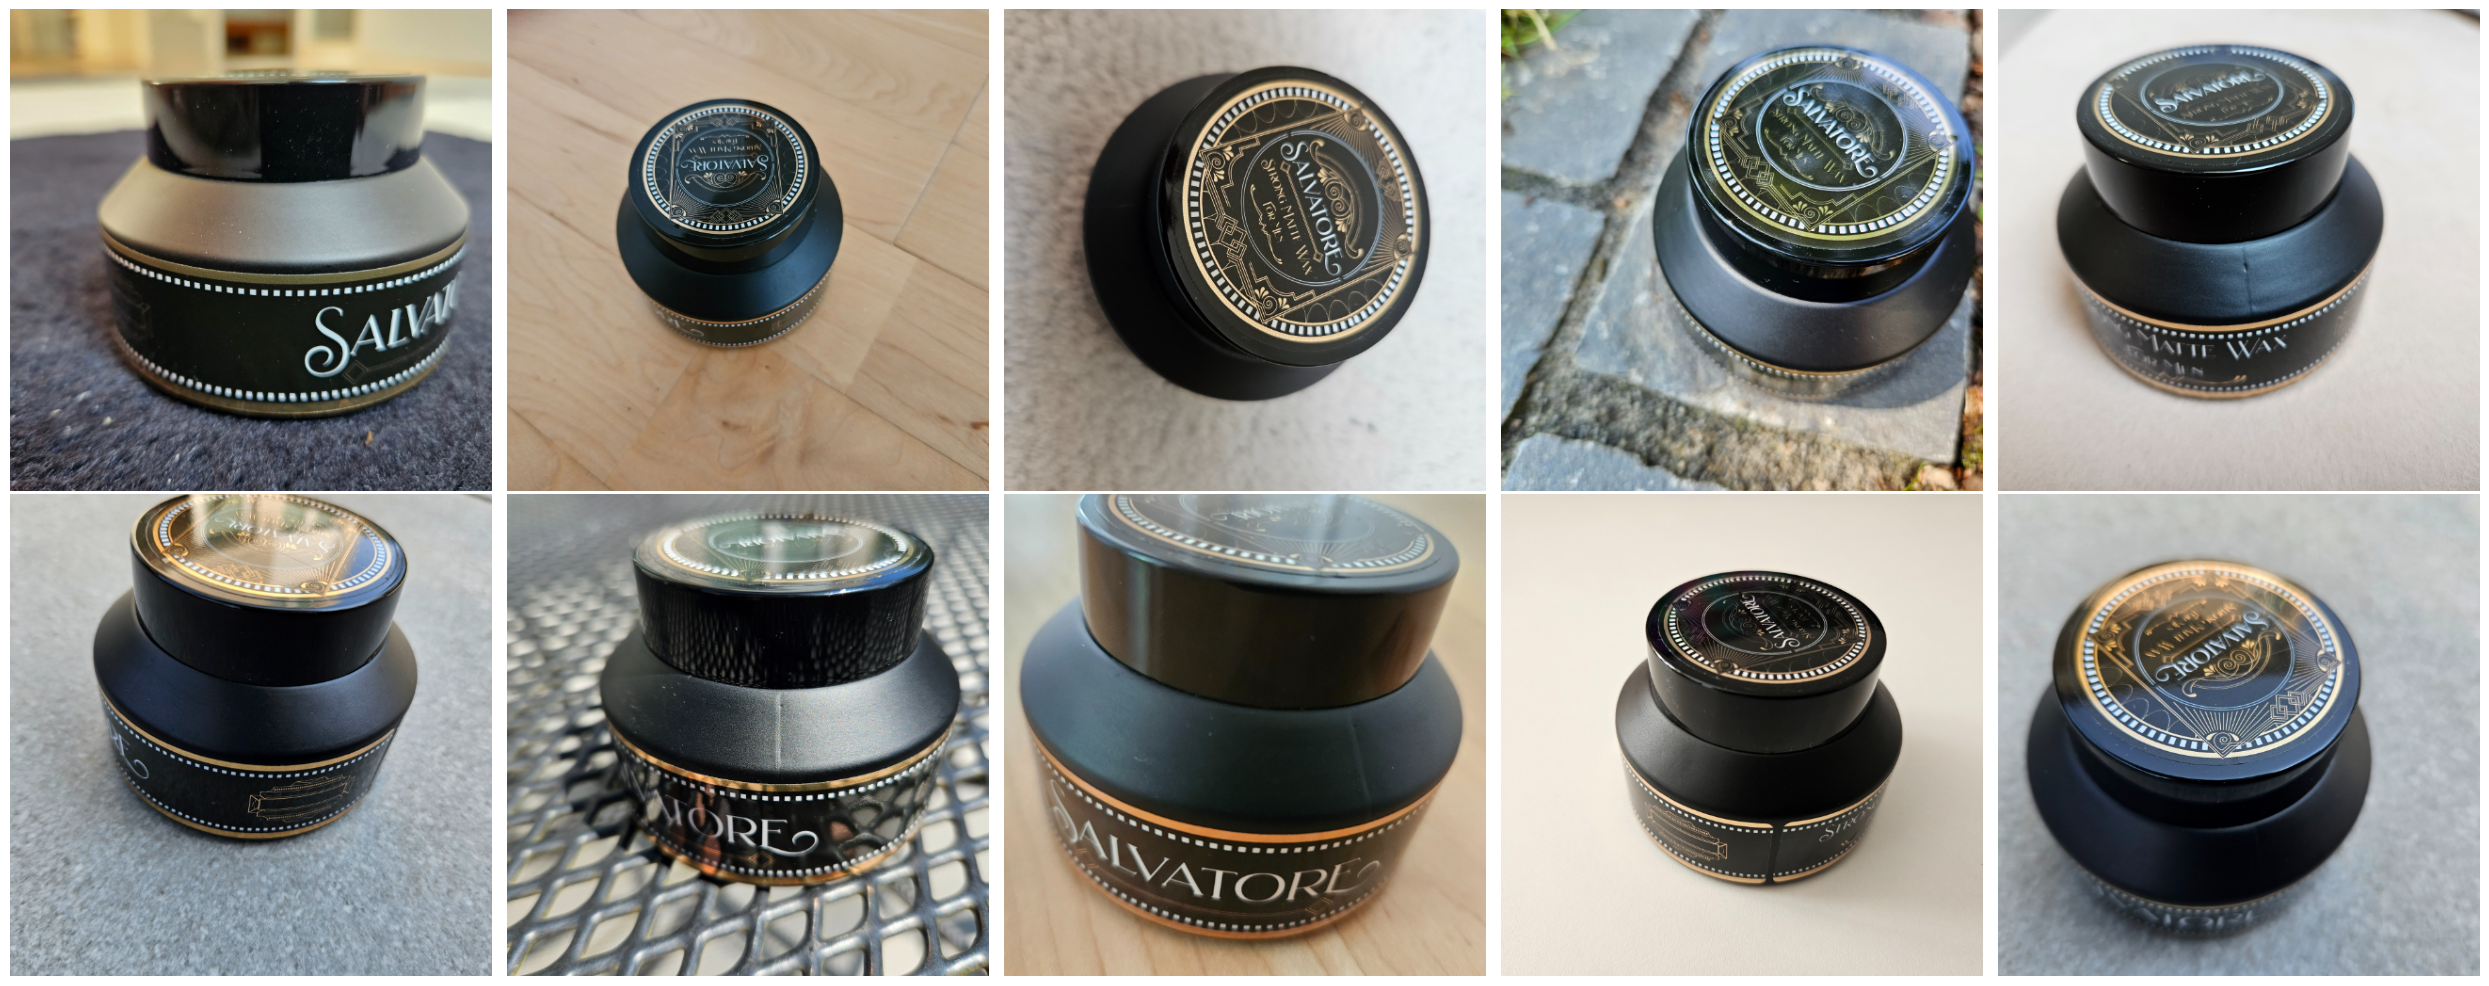

In [56]:
image_list = [os.path.join(local_train_data, image) for image in os.listdir(local_train_data) if image.endswith('.png') or image.endswith('.jpeg') or image.endswith('.jpg')]

show_images(images=image_list[:10], cols=5, source='local')

# Configure and Submit Fine-Tuning Job

We have validated the solution through multiple fine-tuning runs, employing the `runwayml/stable-diffusion-v1-5` and `SG161222/Realistic_Vision_V2.0` models (refer to the `--pretrained_modelname_or_path parameter` in the cell below). The quality of the resulting model can be significantly influenced by various hyperparameters, including training steps, prompts, learning rate, and so on.

For guidance on configuring Dreambooth experiments to achieve optimal results, we recommend reviewing this [blogpost](https://huggingface.co/blog/dreambooth).

In [44]:
# Retrieve latest version of dataset
latest_version = [dataset.latest_version for dataset in ml_client.data.list() if dataset.name == azureml_dataset_name][0]
dataset_asset = ml_client.data.get(name= azureml_dataset_name, version= latest_version)
print(f'Latest version of {azureml_dataset_name}: {latest_version}')

inputs = {"input_data": Input(type=AssetTypes.URI_FOLDER, path=f'azureml:{azureml_dataset_name}:{latest_version}'),}
outputs = {"output_dir": Output(type=AssetTypes.URI_FOLDER)}

# models
# runwayml/stable-diffusion-v1-5
# SG161222/Realistic_Vision_V2.0

job = command(
    inputs = inputs,
    outputs = outputs,
    code = "./src",
    command = '''python prepare.py && accelerate launch --num_processes 1 train_dreambooth.py \
                --pretrained_model_name_or_path="SG161222/Realistic_Vision_V2.0" \
                --instance_data_dir=${{inputs.input_data}} \
                --class_data_dir="outputs/class-images" \
                --output_dir="outputs/models" \
                --train_text_encoder \
                --with_prior_preservation --prior_loss_weight=1.0 \
                --enable_xformers_memory_efficient_attention \
                --instance_prompt="photo of zwx hairwax" \
                --class_prompt="photo of hairwax" \
                --resolution=512 \
                --checkpointing_steps=500 \
                --train_batch_size=2 \
                --validation_prompt="photo of zwx hairwax" \
                --num_validation_images=4 \
                --validation_steps=100 \
                --gradient_accumulation_steps=1 \
                --scale_lr \
                --gradient_checkpointing \
                --learning_rate=1e-7 --lr_scheduler="constant" \
                --lr_warmup_steps=0 \
                --num_class_images=600 \
                --max_train_steps=2000 && python inference.py --model_path outputs/models''',
    environment_variables = {"PYTORCH_CUDA_ALLOC_CONF": "max_split_size_mb:100"},
    environment = "dreambooth-env@latest",
    compute = train_target, 
    experiment_name = experiment_name,
    display_name= "Dreambooth hairwax product example, RV 2.0, 2k steps",
    )

returned_job = ml_client.jobs.create_or_update(job)
returned_job



Command({'parameters': {}, 'init': False, 'name': 'khaki_soca_5mvzkbdyjr', 'type': 'command', 'status': 'Starting', 'log_files': None, 'description': None, 'tags': {}, 'properties': {'mlflow.source.git.repoURL': 'https://github.com/Azure/gen-cv', 'mlflow.source.git.branch': 'main', 'mlflow.source.git.commit': '1afd5fbeee5c895b9efbca96ffd615b5b8f18d94', 'azureml.git.dirty': 'False', '_azureml.ComputeTargetType': 'amlctrain', 'ContentSnapshotId': '67125fb3-2dc4-4a82-8ba0-d12cb57712aa'}, 'print_as_yaml': True, 'id': '/subscriptions/2dbd7833-129e-4a48-b976-e6dd28a92c29/resourceGroups/gencv/providers/Microsoft.MachineLearningServices/workspaces/gencv-workspace/jobs/khaki_soca_5mvzkbdyjr', 'Resource__source_path': None, 'base_path': '/workspaces/gen-cv/generation-finetuning', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f0880c25f60>, 'serialize': <msrest.serialization.Serializer object at 0x7f0880d62950>, 'allowed_keys': {}, 'key_restriction': False, 'logger': <Logger attr_dict (WARNING)>, 'display_name': 'Dreambooth elephant, SD 1.5, 800 steps', 'experiment_name': 'dreambooth-finetuning', 'compute': 'gpu-cluster', 'services': {'Tracking': {'endpoint': 'azureml://westeurope.api.azureml.ms/mlflow/v1.0/subscriptions/2dbd7833-129e-4a48-b976-e6dd28a92c29/resourceGroups/gencv/providers/Microsoft.MachineLearningServices/workspaces/gencv-workspace?', 'type': 'Tracking'}, 'Studio': {'endpoint': 'https://ml.azure.com/runs/khaki_soca_5mvzkbdyjr?wsid=/subscriptions/2dbd7833-129e-4a48-b976-e6dd28a92c29/resourcegroups/gencv/workspaces/gencv-workspace&tid=72f988bf-86f1-41af-91ab-2d7cd011db47', 'type': 'Studio'}}, 'comment': None, 'job_inputs': {'input_data': {'type': 'uri_folder', 'path': 'elephant:1', 'mode': 'ro_mount'}}, 'job_outputs': {'output_dir': {'type': 'uri_folder', 'mode': 'rw_mount'}, 'default': {'type': 'uri_folder', 'path': 'azureml://datastores/workspaceartifactstore/ExperimentRun/dcid.khaki_soca_5mvzkbdyjr', 'mode': 'rw_mount'}}, 'inputs': {'input_data': <azure.ai.ml.entities._job.pipeline._io.base.NodeInput object at 0x7f0880d61090>}, 'outputs': {'output_dir': <azure.ai.ml.entities._job.pipeline._io.base.NodeOutput object at 0x7f0880d62b60>, 'default': <azure.ai.ml.entities._job.pipeline._io.base.NodeOutput object at 0x7f0880d63520>}, 'component': CommandComponent({'intellectual_property': None, 'auto_increment_version': True, 'source': 'REMOTE.WORKSPACE.JOB', 'is_anonymous': False, 'auto_delete_setting': None, 'name': 'khaki_soca_5mvzkbdyjr', 'description': None, 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': None, 'Resource__source_path': None, 'base_path': PosixPath('.'), 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f0880c25f60>, 'serialize': <msrest.serialization.Serializer object at 0x7f0880c24fd0>, 'command': 'python prepare.py && accelerate launch --num_processes 1 train_dreambooth.py                 --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"                 --instance_data_dir=${{inputs.input_data}}                 --class_data_dir="outputs/class-images"                 --output_dir="outputs/models"                 --train_text_encoder                 --with_prior_preservation --prior_loss_weight=1.0                 --enable_xformers_memory_efficient_attention                 --instance_prompt="photo of zwx wood figure"                 --class_prompt="photo wood figure"                 --resolution=512                 --checkpointing_steps=400                 --train_batch_size=2                 --validation_prompt="photo of zwx wood figure"                 --num_validation_images=4                 --validation_steps=100                 --gradient_accumulation_steps=1                 --scale_lr                 --gradient_checkpointing                 --learning_rate=1e-7 --lr_scheduler="constant"                 --lr_warmup_steps=0                 --num_class_images=600                 --max_train_steps=800 && python infe

# Download Model

In [41]:
job_name = returned_job.name # use above job
# job_name = "yellow_peach_sxd4fbb98p" # pick previous job

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(name=ml_client.workspace_name).mlflow_tracking_uri

# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Initialize MLFlow client
mlflow_client = MlflowClient()

mlflow_run = mlflow_client.get_run(job_name)

mlflow.artifacts.download_artifacts(run_id= mlflow_run.info.run_id, 
                                    artifact_path="outputs/models/", # Azure ML job output
                                    dst_path="./train-artifacts") # local folder

'/workspaces/gen-cv/generation-finetuning/train-artifacts/outputs/models/'

In [45]:
# Workaround: model_index.json is erroneously downloaded as a folder with the model files instead as a file. Manually checking file type and downloading individually if this is the case

json_path = "./train-artifacts/outputs/models/model_index.json"

if os.path.isdir("./train-artifacts/outputs/models/model_index.json"):
    shutil.rmtree(json_path)
    mlflow.artifacts.download_artifacts(run_id= mlflow_run.info.run_id, 
                                    artifact_path="outputs/models/model_index.json", # Azure ML job output
                                    dst_path="./train-artifacts") # local folder

In [46]:
device = "cuda"

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=True)

pipe = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path='./train-artifacts/outputs/models/',
        scheduler=scheduler,
        safety_checker=None,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=False
    ).to(device)

# TODO: enable reuse specific checkpoint: https://huggingface.co/docs/diffusers/training/dreambooth#inference-from-a-saved-checkpoint

Some weights of the model checkpoint at ./train-artifacts/outputs/models/vae were not used when initializing AutoencoderKL: ['decoder.mid_block.attentions.0.to_out.0.weight', 'decoder.mid_block.attentions.0.to_q.bias', 'encoder.mid_block.attentions.0.to_q.weight', 'encoder.mid_block.attentions.0.to_q.bias', 'decoder.mid_block.attentions.0.to_k.weight', 'decoder.mid_block.attentions.0.to_q.weight', 'decoder.mid_block.attentions.0.to_v.bias', 'encoder.mid_block.attentions.0.to_out.0.weight', 'encoder.mid_block.attentions.0.to_k.bias', 'decoder.mid_block.attentions.0.to_k.bias', 'encoder.mid_block.attentions.0.to_out.0.bias', 'decoder.mid_block.attentions.0.to_out.0.bias', 'encoder.mid_block.attentions.0.to_v.weight', 'encoder.mid_block.attentions.0.to_v.bias', 'decoder.mid_block.attentions.0.to_v.weight', 'encoder.mid_block.attentions.0.to_k.weight']
- This IS expected if you are initializing AutoencoderKL from the checkpoint of a model trained on another task or with another architectur

# Generate Images

In [ ]:
def generate_images(prompt, num_images=1):

    suffix = ", (high detailed skin:1.2), 8k uhd, dslr, advertising photography, high quality, film grain, real-world, unedited, photorealistic, Fujifilm XT3, natural"
    negative_prompt = '(semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck'

    images = pipe(prompt=prompt + suffix,
                negative_prompt=negative_prompt,
                height=512,
                width=768,
                guidance_scale=7.5,
                num_inference_steps=50,
                num_images_per_prompt=num_images,
                ).images
    
    return images

prompts = [
"product studio photography of zwx hairwax tin in a human hand",
"product studio photography tin of zwx hairwax on cosmetics shelf",
"product studio photography closeup tin of zwx hairwax with lake in background",
"product studio photography tin of zwx hairwax in sand with desert sunset in background",
"A magical zwx hairwax tin, futuristic, stunning product studio photography, low-key lighting, bokeh, smoke effects",
"product studio photography tin of zwx hairwax on icy lake with reflections. bokeh, blue sky.",
]

shutil.rmtree(generated_images)
if not os.path.exists(generated_images):
    os.makedirs(generated_images)

for prompt in prompts:
        image = generate_images(prompt)[0]

        rand_num = random.randint(100000, 999999)
        image.save(os.path.join(generated_images, f"image-{rand_num}.png"))


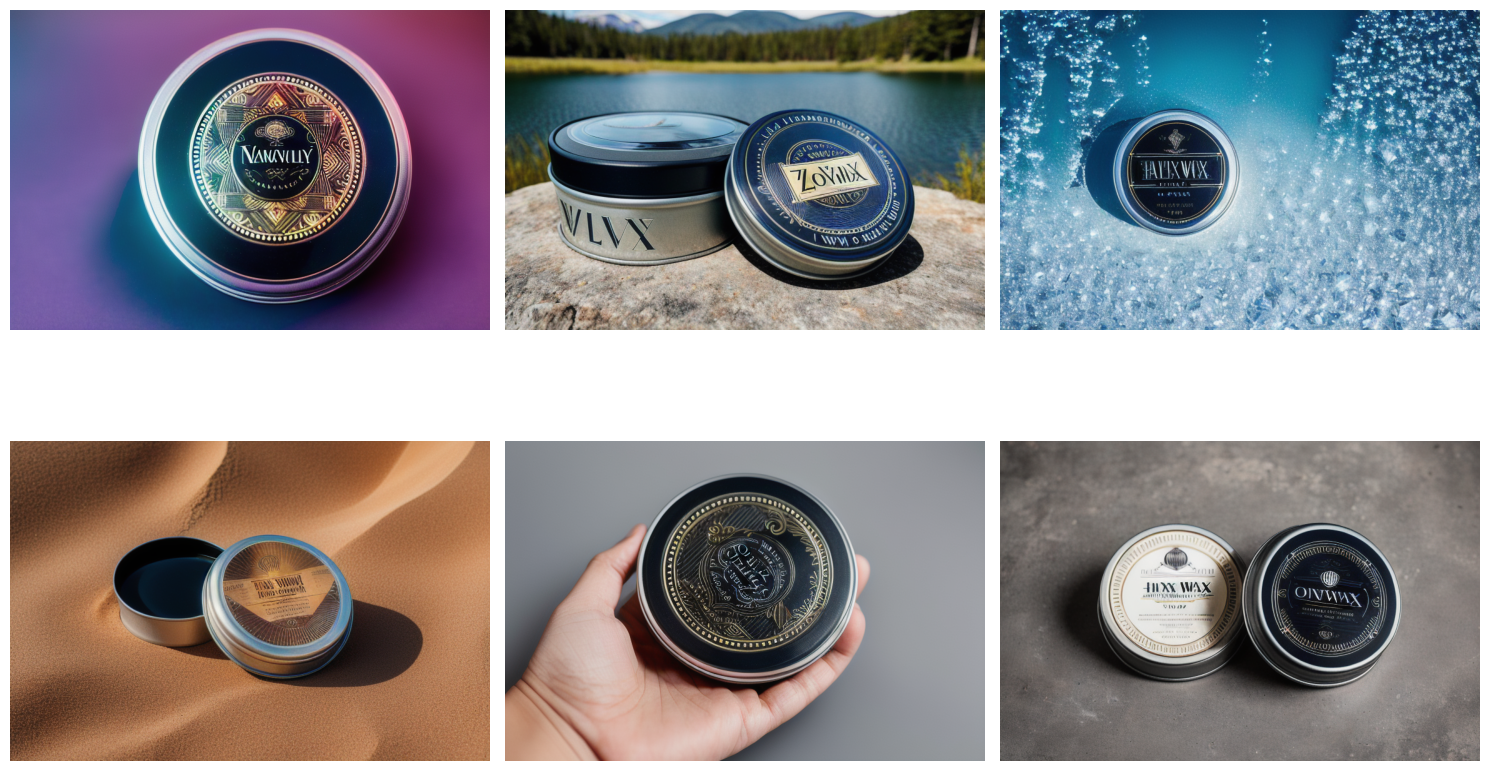

In [52]:
image_list = [os.path.join(generated_images, image) for image in os.listdir(generated_images) if image.endswith('.png')]

show_images(images=image_list, cols=3, source='local')